Found cached dataset parquet (C:/Users/HououinKyouma/.cache/huggingface/datasets/Maysee___parquet/Maysee--tiny-imagenet-35af7c46a941f08e/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/2 [00:00<?, ?it/s]

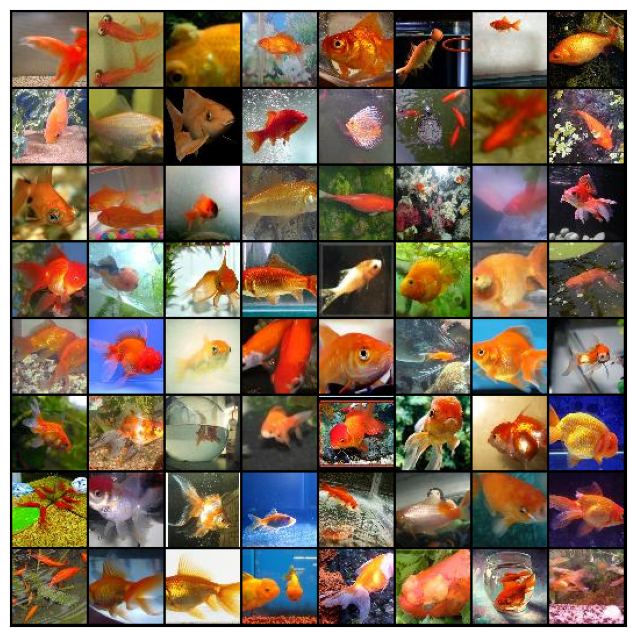

In [1]:
import os
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torchvision.utils import make_grid
from torchvision.utils import save_image
from tqdm.notebook import tqdm
from dataset import Dataset
from configuration import config

batch_size = config.dataloader.batch_size
ds = Dataset.load(**config.dataset)
dataloader = ds.dataloader(**config.dataloader, type='train')

def denormalize(images):
  return images * 0.5 + 0.5

def show_images(images):
  figure, ax = plt.subplots(figsize=(8, 8))
  ax.set_xticks([])
  ax.set_yticks([])

  ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))

def show_batch(dataloader):
  for (images, _) in dataloader:
    images = images.detach()[:64]

    show_images(denormalize(images))
    break

show_batch(dataloader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


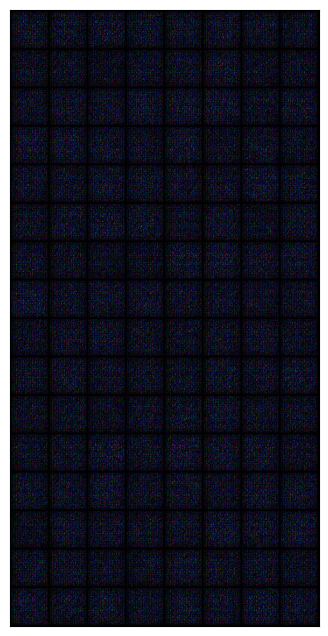

In [2]:
from discriminator import Discriminator
from generator import Generator
from weights import initialize_weights

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
discriminator = Discriminator(use_gpu=config.use_gpu, scale=64).apply(initialize_weights).to(device)
generator = Generator(use_gpu=config.use_gpu, scale=64).apply(initialize_weights).to(device)

latent_size = 128
noises = torch.randn(batch_size, latent_size, 1, 1).to(device)
noise_images = generator(noises)

show_images(noise_images.cpu())

In [30]:
from torch.nn import BCELoss
def save_samples(index, noises, show=True):
  images = generator(noises)

  filename = f'output-images-{index:0=4d}.png'
  save_image(denormalize(images), os.path.join(output_directory, filename), nrow=8)
  print(f'Saving {filename}')

  if show:
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images.cpu().detach(), nrow=8).permute(1, 2, 0))

criterion = BCELoss()

def train_discriminator(images, optimizer):
  optimizer.zero_grad()

  images_predictions = discriminator(images)
  images_targets = torch.ones(images.size(0), 1, device=device)
  images_targets = images_targets * 0.9

  images_loss = criterion(images_predictions, images_targets)
  images_score = torch.mean(images_predictions).item()

  noises = torch.randn(batch_size, latent_size, 1, 1, device=device)
  noises_images = generator(noises)

  noises_targets = torch.zeros(noises_images.size(0), 1, device=device)
  noises_targets = noises_targets + 0.1

  noises_predictions = discriminator(noises_images)
  noises_loss = criterion(noises_predictions, noises_targets)
  noises_score = torch.mean(noises_predictions).item()

  loss = images_loss + noises_loss
  loss.backward()
  optimizer.step()

  return loss.item(), images_score, noises_score

def train_generator(optimizer):
  optimizer.zero_grad()

  noises = torch.randn(batch_size, latent_size, 1, 1, device=device)
  noises_images = generator(noises)

  predictions = discriminator(noises_images)
  targets = torch.ones(batch_size, 1, device=device)
  loss = criterion(predictions, targets)

  loss.backward()
  optimizer.step()

  return loss.item()

def fit(discriminator, generator, dataloader, epochs, learning_rate):
  torch.cuda.empty_cache()

  losses_generator = []
  losses_discriminator = []
  images_scores = []
  noises_scores = []
  fid_scores = []

  optimizer_discriminator = torch.optim.AdamW(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
  optimizer_generator = torch.optim.AdamW(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

  for epoch in range(epochs):
    for images, _ in tqdm(dataloader):
      images = images.to(device)

      loss_discriminator, images_score, noises_score = train_discriminator(images, optimizer_discriminator)
      loss_generator = train_generator(optimizer_generator)

    losses_generator.append(loss_generator)
    losses_discriminator.append(loss_discriminator)

    images_fid = images[:8].type(torch.uint8).cpu()
    noises_fid = generator(noises[:8]).type(torch.uint8).cpu()
    fid = FrechetInceptionDistance(feature=2048)
    fid.update(images_fid, real=True)
    fid.update(noises_fid, real=False)
    fid_score = fid.compute()

    fid_scores.append(fid_score)
    images_scores.append(images_score)
    noises_scores.append(noises_score)

    print(
      f"Epoch [{epoch + 1}/{epochs}]"
      f" loss_generator: {loss_generator:.4f}"
      f" loss_discriminator: {loss_discriminator:.4f}"
      f" images_score: {images_score:.4f}"
      f" noises_score: {noises_score:.4f}"
      f" fid_score: {fid_score:.4f}"
    )

    save_samples(epoch, constant_noise, show=False)

  return losses_generator, losses_discriminator, images_scores, noises_scores


In [4]:
from torch.nn.functional import adaptive_avg_pool2d
from numpy.linalg import linalg
import numpy as np
from torchmetrics.image.fid import FrechetInceptionDistance


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving output-images-0000.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [1/50] loss_generator: 3.9283 loss_discriminator: 1.3649 images_score: 0.5295 noises_score: 0.1996 fid_score: 3.2428
Saving output-images-0000.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [2/50] loss_generator: 6.1508 loss_discriminator: 1.1367 images_score: 0.6752 noises_score: 0.2621 fid_score: 2.4066
Saving output-images-0001.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [3/50] loss_generator: 6.5388 loss_discriminator: 1.0664 images_score: 0.6684 noises_score: 0.0300 fid_score: 2.9186
Saving output-images-0002.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [4/50] loss_generator: 5.8303 loss_discriminator: 1.0709 images_score: 0.6688 noises_score: 0.0638 fid_score: 3.3632
Saving output-images-0003.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [5/50] loss_generator: 12.6320 loss_discriminator: 4.2369 images_score: 0.9068 noises_score: 0.9773 fid_score: 2.0304
Saving output-images-0004.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [6/50] loss_generator: 10.8353 loss_discriminator: 1.2648 images_score: 0.6445 noises_score: 0.0034 fid_score: 3.4870
Saving output-images-0005.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [7/50] loss_generator: 5.5470 loss_discriminator: 1.1735 images_score: 0.6754 noises_score: 0.0045 fid_score: 3.1609
Saving output-images-0006.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [8/50] loss_generator: 13.1116 loss_discriminator: 2.6186 images_score: 0.8582 noises_score: 0.8834 fid_score: 2.6534
Saving output-images-0007.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [9/50] loss_generator: 12.7324 loss_discriminator: 1.2898 images_score: 0.7819 noises_score: 0.0004 fid_score: 2.2416
Saving output-images-0008.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [10/50] loss_generator: 3.2130 loss_discriminator: 0.8775 images_score: 0.7627 noises_score: 0.0418 fid_score: 2.7478
Saving output-images-0009.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [11/50] loss_generator: 1.7419 loss_discriminator: 0.8435 images_score: 0.8302 noises_score: 0.0300 fid_score: 3.5061
Saving output-images-0010.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [12/50] loss_generator: 2.0436 loss_discriminator: 0.7623 images_score: 0.8288 noises_score: 0.0806 fid_score: 3.4019
Saving output-images-0011.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [13/50] loss_generator: 2.9471 loss_discriminator: 0.9312 images_score: 0.8414 noises_score: 0.0077 fid_score: 2.2484
Saving output-images-0012.png


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [14/50] loss_generator: 2.4409 loss_discriminator: 0.8465 images_score: 0.8752 noises_score: 0.0131 fid_score: 2.1241
Saving output-images-0013.png


  0%|          | 0/4 [00:00<?, ?it/s]

KeyboardInterrupt: 

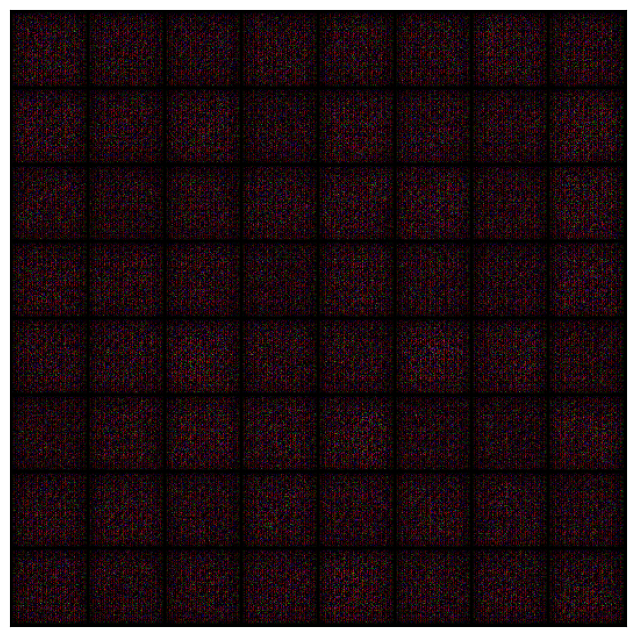

In [29]:
scales = [64]
learning_rate = 0.0002
epochs = 50

for generator_scale in scales:
  for discriminator_scale in reversed(scales):
    generator = (
      Generator(use_gpu=config.use_gpu, scale=generator_scale)
      .apply(initialize_weights)
      .to(device)
    )
    discriminator = (
      Discriminator(use_gpu=config.use_gpu, scale=discriminator_scale)
      .apply(initialize_weights)
      .to(device)
    )

    output_directory = f'results/{generator_scale}-{discriminator_scale}'
    model_directory = f'models/{generator_scale}-{discriminator_scale}'
    os.makedirs(output_directory, exist_ok=True)

    os.makedirs(output_directory, exist_ok=True)
    constant_noise = torch.randn(64, latent_size, 1, 1, device=device)
    save_samples(0, constant_noise)

    history = fit(
      discriminator,
      generator,
      dataloader,
      epochs=epochs,
      learning_rate=learning_rate
    )


    torch.save(generator.state_dict(), f'{model_directory}-generator.pt')
    torch.save(discriminator.state_dict(), f'{model_directory}-discriminator.pt')


# generator.load_state_dict(torch.load('generator.pt'))
# discriminator.load_state_dict(torch.load('discriminator.pt'))